## Automatic Ticket Classification - Case Study

### Submitted by: Umesh Pendurkar


## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

# # Part 1. Data Loading

### Step 1: Install and import the libraries and modules

In [2]:
# !pip install plotly

In [8]:
!pip install textblob

In [10]:
!pip install wordcloud

In [12]:
!pip install xgboost

In [14]:
!pip install catboost

In [39]:
!pip install gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24


In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

###  Step 2: Loading the Data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 

# Write the path to your data file and load it 
f = open('complaints-2021-05-14_08_16.json',)

# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

__________________________________________________________________________________________________________
__________________________________________________________________________________________

## Part 2 : Text Preprocessing

### Step 1 : Data Preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

#### The customer complaint are in "`_source.complaint_what_happened`" variable

In [5]:
# Rename column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [6]:
# Inspect the number of missing values
df.isna().sum().sort_values(ascending=False)

company_public_response      78309
tags                         67413
sub_issue                    46297
sub_product                  10571
zip_code                      6757
state                         1991
consumer_consent_provided     1008
company                          0
complaint_what_happened          0
timely                           0
date_sent_to_company             0
submitted_via                    0
index                            0
company_response                 0
type                             0
consumer_disputed                0
date_received                    0
issue                            0
complaint_id                     0
score                            0
id                               0
product                          0
dtype: int64

In [7]:
df.shape

(78313, 22)

In [8]:
# No. of rows that are empty under complaints column 
len(df[df['complaint_what_happened'] == ""])

57241

In [9]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

# Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

# Check again 
len(df[df['complaint_what_happened'] == ""])

0

In [10]:
df.shape

(21072, 22)

Total removed are 78313 - 21072 = 57241 rows that contained blank under complaints column

### Step 2 : Prepare the Text for Topic Modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [12]:
# Apply the above function to complaint column
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))

# View first few rows of cleaned data
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [13]:
# Write your function to Lemmatize the texts
def lemmatizer(text):     
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)

In [14]:
# Dataframe('df_clean') will have only the complaints and the lemmatized complaints 

# Add a column for lemmatized complaints to the dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [15]:
# Write your function to extract the POS tags 
def get_singular_nouns(text):

    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# Apply the function to create a new column containing only singular nouns 
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_nouns(x['lemmatized_complaint']), axis=1)

In [16]:
# The clean dataframe should now contain the raw complaint, 
# lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


___
___

## Part 3 : Exploratory Data Analysis (EDA)

Write the code in this Step to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘



### Step 1 : Visualise the data according to the 'Complaint' character length

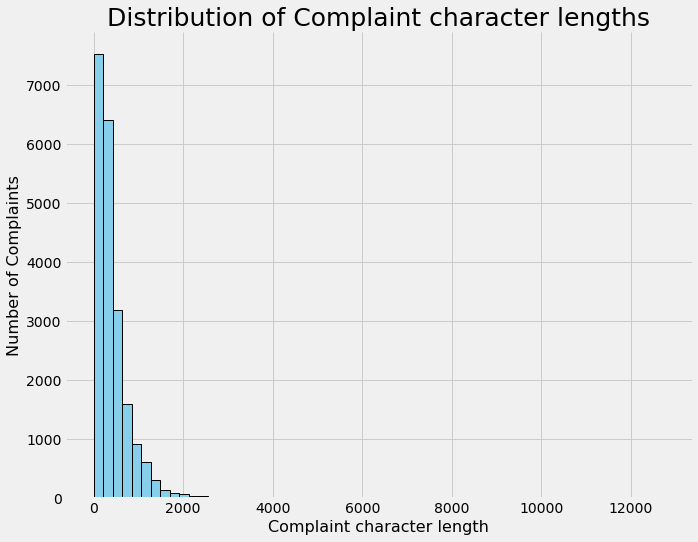

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length

# list of pre-processed complaints
doc_compLen = [len(d) for d in df_clean['complaint_POS_removed']]

# plot
plt.figure(figsize=(10,8))
plt.hist(doc_compLen, color = "skyblue", lw=1, edgecolor='black', bins = 60)
plt.title('Distribution of Complaint character lengths', fontsize=25)
plt.ylabel('Number of Complaints', fontsize=16)
plt.xlabel('Complaint character length', fontsize=16)
sns.despine()
plt.show()


###  Step 2 : Using a word cloud find the top 40 words by frequency among all the articles after processing the text

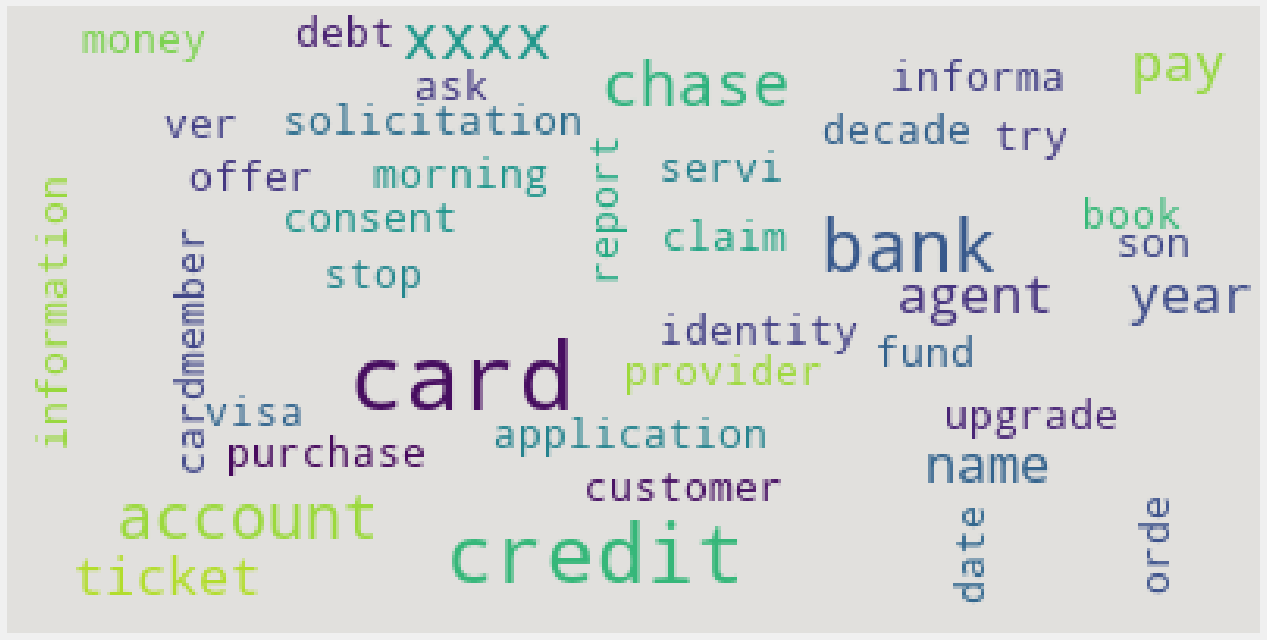

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='#E1E0DD',
                      stopwords=stopwords,
                      max_words=40,
                      min_font_size=10,
                      max_font_size=30, 
                      random_state=40
                      ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

### Step 3 : Top Unigrams, Bigrams and Trigrams by Frequency among all the Complaints after Processing the Text

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [21]:
common_words = get_top_n_words(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

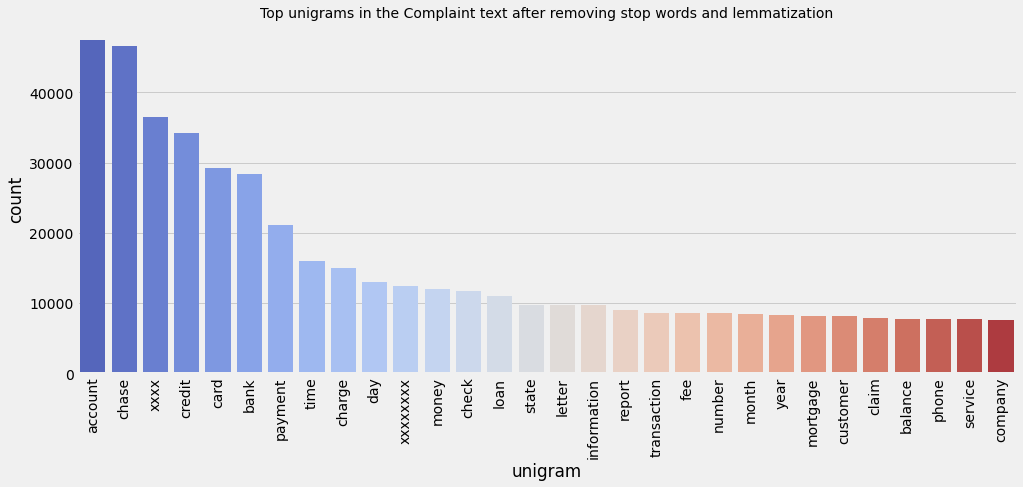

In [22]:
# Plot the top unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top unigrams in the Complaint text after removing stop words and lemmatization", fontsize=14)
plt.show()

In [23]:
#Print the top 10 words in the unigram frequency
df2.head(10)

,unigram,count
0,account,47433
1,chase,46575
2,xxxx,36469
3,credit,34151
4,card,29286
5,bank,28411
6,payment,21168
7,time,16044
8,charge,15013
9,day,12972


In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

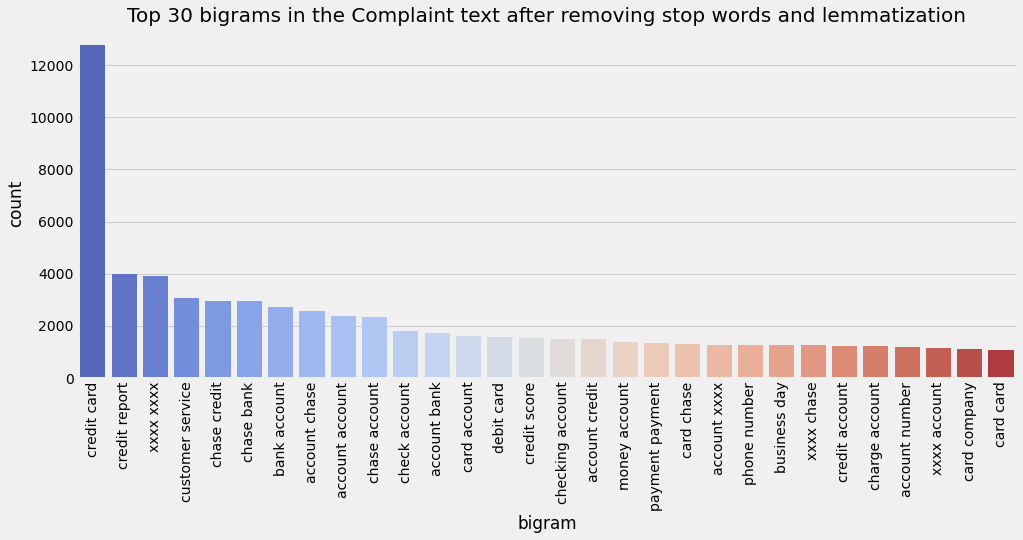

In [25]:
# Top 30 bigrams by frequency among all the complaints
common_words = get_top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [26]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,credit card,12779
1,credit report,3988
2,xxxx xxxx,3915
3,customer service,3081
4,chase credit,2957
5,chase bank,2947
6,bank account,2737
7,account chase,2583
8,account account,2386
9,chase account,2327


In [27]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

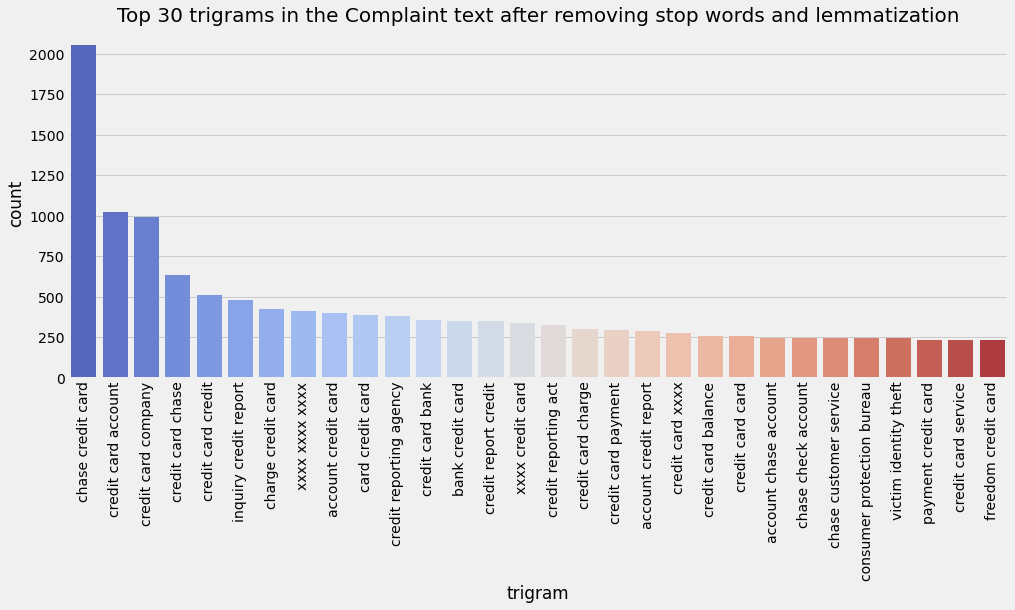

In [28]:
# Top 30 trigrams by frequency among all the complaints
common_words = get_top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [29]:
#Print the top 10 words in the trigram frequency
df4.head(10)

,trigram,count
0,chase credit card,2057
1,credit card account,1025
2,credit card company,992
3,credit card chase,632
4,credit card credit,514
5,inquiry credit report,481
6,charge credit card,422
7,xxxx xxxx xxxx,414
8,account credit card,399
9,card credit card,388


### 📌 <span style="color:green">The personal details of customer has been masked in the dataset with 'xxxx'</span>
### <span style="color:green">Let's remove the masked text as this will be of no use for our analysis</span>

In [30]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [31]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


___
___

## Part 4 : Feature Extraction

###  Convert the Raw Texts to a Matrix of TF-IDF Features

***Note***: Here, we use following parameters of TfidfVectorizer:-

**`max_df`** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**`min_df`** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [32]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

### Create a document term matrix using fit_transform

- The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
 - The tuples that are not there have a tf-idf score of 0

In [33]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

___
___

## Part 5 : Topic Modelling using NMF

- `Non-Negative Matrix Factorization (NMF)` is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.


- We will perform the following steps:

    * Find the best number of clusters/topics
    * Apply the best number to create word clusters/topics
    * Inspect & validate the correction of each cluster for each complaint
    * Correct the labels if needed 
    * Map the clusters to topics/cluster names

### Step 1 : Find the best number of clusters/topics

###  To select best number of Topics, we will use Coherence Model

- With the Coherence Model we will see how to automatically select the best number of topics. 

In [1]:
# Use Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

NameError: name 'df_clean' is not defined

In [35]:
from sklearn.decomposition import NMF

### Step 2 : Find the best number of clusters/topics Manually

### 💠 Manual Topic Modeling

You need to do take the trial & error approach to find the best num of topics for your NMF model.

- With the Coherence Model we got the **best number of topics = 5**.

- The hard work is already done at this point so all we need to do is run the model.

- The only parameter that is required is the number of components i.e. the number of topics we want. 
- This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state=40
nmf_model = NMF(n_components=5, random_state=40) #write your code here

In [37]:
#Fit the model on document term matrix
nmf_model.fit(dtm)

#The number of features
len(tfidf.get_feature_names())

7288

In [38]:
#Top 10 word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

number
day
branch
deposit
chase
fund
money
check
bank
account


In [39]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'The TOP-15 words for each of the topics #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

The TOP-15 words for each of the topics #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


The TOP-15 words for each of the topics #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


The TOP-15 words for each of the topics #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


The TOP-15 words for each of the topics #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


The TOP-15 words for each of the topics #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [40]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2], dtype=int64)

In [41]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [42]:
#Review the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,4
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,0


In [43]:
#Print the first 5 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,0
35,i opened the saving account for the bonus i w...,I open the save account for the bonus I be s...,save account bonus bonus auto transfer check t...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,1


### After looking carefully at the first 5 complaints for each topics, we can assign names to topics as below
- `Topic 0`: **Bank Account services**
- `Topic 1`: **Credit card or prepaid card**
- `Topic 2`: **Others**
- `Topic 3`: **Theft/Dispute Reporting**
- `Topic 4`: **Mortgage/Loan**


### Step 3 : Map the clusters to topics/cluster names

### We create a dictionary and map the above names to the 5 topics

In [44]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
# View the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,Bank Account services


___
___

## Part 6 : Model Building using Supervised Learning

### Step 1 : Supervised Model to predict any new complaints to the relevant Topics

 - You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

 - Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [46]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topic Names with Topic numbers
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [47]:
# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,4
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,0


### Step 2 : Supervised Model Training

In [48]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened", "Topic"]]

In [49]:
# View the training data
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0


In [50]:
# View dimensions of training data
training_data.shape

(21072, 2)

In [51]:
# View value counts of the five topics
training_data['Topic'].value_counts()

0    5232
1    5004
3    4755
4    3823
2    2258
Name: Topic, dtype: int64

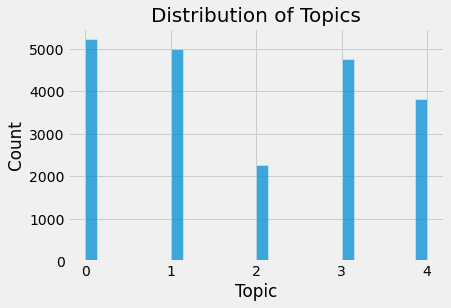

In [52]:
# Plot a histogram of classes (i.e. topics)
sns.histplot(data=training_data, x='Topic')
plt.title("Distribution of Topics", fontsize=20)
plt.show()

### Selection of Evaluation Metric 

- As the distribution of target variable is not normal and there is imbalance of classes, we select **F1 Score** as our evaluation metric for comparing the performance of various models we will build.
- Moreover, we will use a **weighted average** method for evaluating `F1 Score` due to the imbalance of classes

### Step 3 : Apply the Supervised Model

###  We can now apply the supervised models on the training data created. 

- In this process, we will do the following:
    * Create the vector counts using Count Vectorizer
    * Transform the word vector to tf-idf
    * Create the train & test data using the train_test_split on the tf-idf & topics


In [53]:
# Get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

In [54]:
# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [55]:
# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [56]:
# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [57]:
# Create Train-Test split sets
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, 
                                                    test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33599)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33599)
Shape of y_test: (5268,)


### 💠 Now, we will try the following models one by one and evaluate them to select the best performing one

1. Naive Bayes (this will serve as a baseline model)
2. Logistic regression
3. Decision Tree
4. Random Forest
5. Support Vector Machine
6. XGBoost
7. CatBoost

Using the required evaluation metrics judge the tried models and select the ones performing the best**

___
___

## Part 7 : Model Training using Various Models and Evaluations

### Step 1 : Function to Evaluate the Classifiers

In [69]:
# Write your code here to build any 3 models and evaluate them using the required metrics
def eval_model(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, 
                                target_names=["Bank Account services", 
                                              "Credit card or prepaid card", "Others", 
                                              "Theft/Dispute Reporting",
                                              "Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(8, 5))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, 
                cmap="Blues", fmt='d', 
                xticklabels=["Bank Account services", "Credit card or prepaid card", 
                             "Others", "Theft/Dispute Reporting",
                             "Mortgage/Loan"], 
                yticklabels=["Bank Account services", "Credit card or prepaid card", 
                             "Others", "Theft/Dispute Reporting",
                             "Mortgage/Loan"])
    plt.show()
    
    return



### Model #1 : Naive Bayes Theorem

In [60]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
%time
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

Wall time: 0 ns


In [63]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
print("The Naive Bayes Classifier's F1 Score : ", round(f1_nb,2))

The Naive Bayes Classifier's F1 Score :  0.68


In [64]:
# Hyperparameter tuning to improve Naive Bayes performance
param_grid_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=clf_nb, 
                       param_grid=param_grid_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


**Best Estimator parameters**

{'alpha': 0.1, 'fit_prior': False}

In [65]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

Wall time: 0 ns


In [66]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
print("The Tuned Naive Bayes Classifier's F1 Score : ", round(f1_nb_tuned,2))

The Tuned Naive Bayes Classifier's F1 Score :  0.78


CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.84      0.81      1321
Credit card or prepaid card       0.80      0.76      0.78      1277
                     Others       0.68      0.63      0.65       553
    Theft/Dispute Reporting       0.77      0.78      0.78      1197
              Mortgage/Loan       0.83      0.84      0.84       920

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



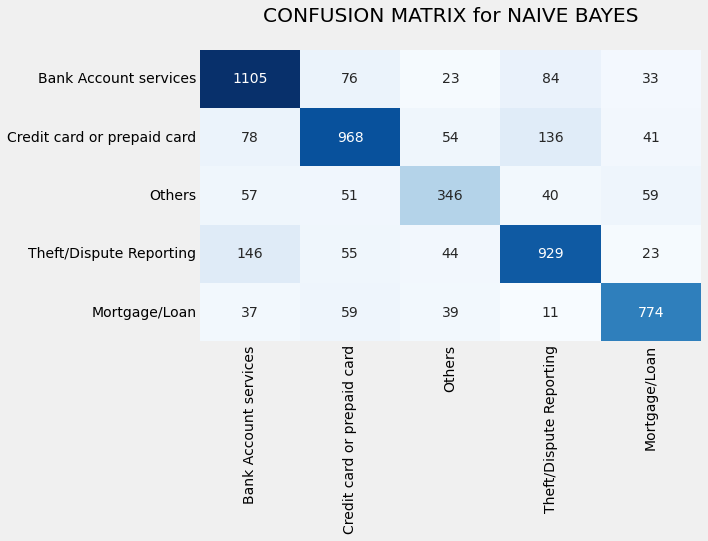

In [70]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

In [68]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score (Untuned Model)': round(f1_nb, 2), 
                         'F1 Score (Tuned Model)': round(f1_nb_tuned, 2)}])
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78


The tuned Naive Bayes model gives a moderately well `F1 score` of `0.78`

However, this model performed poorly on classifying `Others` as compared to remaining four topics

### Model #2: Logistic Regression

In [71]:
# Run the Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

Wall time: 0 ns


In [72]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
print("The Logistic Regression model's F1 Score : ", round(f1_lr,2))

The Logistic Regression model's F1 Score :  0.92


In [73]:
# Hyperparameter tuning to improve Logistic Regression performance
param_grid_lr = {
    'penalty': ['l1', 'l2','elasticnet', 'none'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=clf_lr, 
                       param_grid=param_grid_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


**Best Estimator parameters**

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

In [74]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

Wall time: 0 ns


In [75]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
print("The Tuned Logistic Regression model's F1 Score : ", round(f1_lr_tuned,2))

The Tuned Logistic Regression model's F1 Score :  0.95


CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1321
Credit card or prepaid card       0.95      0.96      0.95      1277
                     Others       0.93      0.96      0.95       553
    Theft/Dispute Reporting       0.95      0.91      0.93      1197
              Mortgage/Loan       0.94      0.94      0.94       920

                   accuracy                           0.95      5268
                  macro avg       0.94      0.95      0.95      5268
               weighted avg       0.95      0.95      0.95      5268



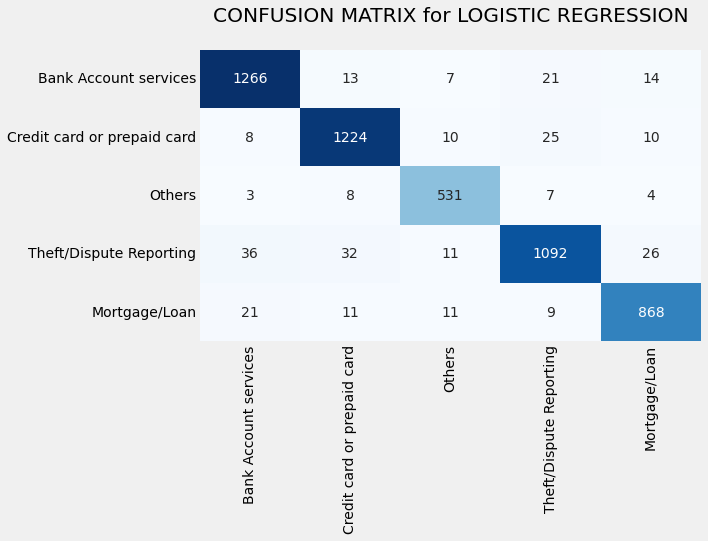

In [76]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

In [77]:
# Update the summary table
summary.loc[len(summary.index)] = ['Logistic Regression', round(f1_lr, 2), round(f1_lr_tuned, 2)]
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95


The tuned Logistic Regression model gives a pretty high `F1 score` of `0.94`

This model also performed well on all the topics

### Model #3:  Decision Tree 

In [78]:
# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

Wall time: 0 ns


In [79]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
print("The Decision Tree model's F1 Score : ", round(f1_dt,2))

The Decision Tree model's F1 Score :  0.78


In [80]:
# Hyperparameter tuning to improve Decision Tree performance
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    'max_features':['auto','log2','sqrt',None],
}

grid_dt = GridSearchCV(estimator=clf_dt, 
                       param_grid=param_grid_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 15}


**Best Estimator parameters**

{'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 15}

In [81]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

Wall time: 0 ns


In [82]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
print("The Tuned Decision Tree model's F1 Score : ", round(f1_dt_tuned,2))

The Tuned Decision Tree model's F1 Score :  0.8


CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.81      0.83      0.82      1321
Credit card or prepaid card       0.83      0.83      0.83      1277
                     Others       0.80      0.77      0.78       553
    Theft/Dispute Reporting       0.76      0.75      0.76      1197
              Mortgage/Loan       0.83      0.83      0.83       920

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



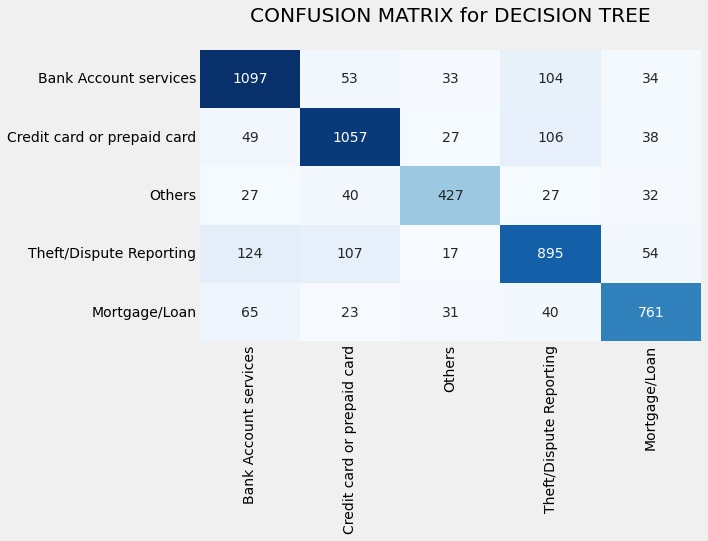

In [83]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

In [84]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95
2,Decision Tree,0.78,0.80


The tuned Decision Tree model gives a decent F1 score of 0.8

However, this model was not able to perform well on classifying `Others` and `Theft/Dispute Reporting` topics

### Model #4:  Random Forest

In [85]:
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [86]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
print("The Random Forest model's F1 Score : ", round(f1_rf,2))

The Random Forest model's F1 Score :  0.81


In [88]:
# Hyperparameter tuning to improve Random Forest performance
# param_grid_rf = {
#     'n_estimators': [100, 200, 300, 500, 800],
#     'criterion':['gini','entropy'],
#     'max_depth': [10, 30, 40],
#     'min_samples_split': [1, 5, 10],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['log2', 'sqrt', None]    
# }

# grid_rf = RandomizedSearchCV(estimator=clf_rf, 
#                        param_distributions=param_grid_rf,
#                        scoring='f1_weighted',
#                        verbose=1,
#                        n_jobs=-1,
#                        cv=5)
# grid_rf.fit(X_train, y_train)
# print(grid_rf.best_params_)

Best Estimator parameters

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 30, 'criterion': 'gini'}

In [90]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

Wall time: 0 ns


In [91]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
print("The Tuned Random Forest model's F1 Score : ", round(f1_rf_tuned,2))

The Tuned Random Forest model's F1 Score :  0.84


CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.85      0.86      0.86      1321
Credit card or prepaid card       0.86      0.87      0.87      1277
                     Others       0.82      0.82      0.82       553
    Theft/Dispute Reporting       0.83      0.79      0.81      1197
              Mortgage/Loan       0.85      0.87      0.86       920

                   accuracy                           0.84      5268
                  macro avg       0.84      0.84      0.84      5268
               weighted avg       0.84      0.84      0.84      5268



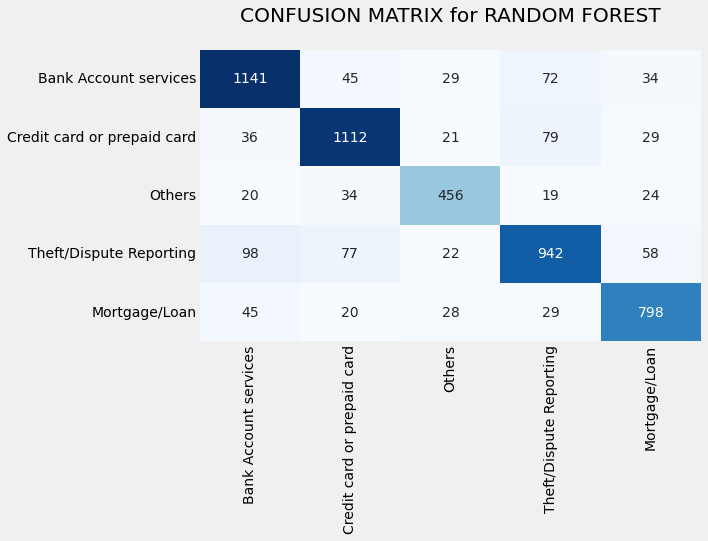

In [92]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

In [93]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95
2,Decision Tree,0.78,0.80
3,Random Forest,0.81,0.84


The tuned Random Forest classifier gives a better `F1 score` of `0.84`

This model performed quite well on all the topics

### Model #5: Support Vector Machine

In [94]:
# Run the Support Vector Machine (SVM) model on default hyperparameters
model_name = 'SUPPORT VECTOR MACHINE'
clf_svm = SVC()
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

In [95]:
# Calculate F1 Score using weighted average method
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
print("The Support Vector Machine (SVM) model's F1 Score : ", round(f1_svm, 2))

The Support Vector Machine (SVM) model's F1 Score :  0.92


In [ ]:
# # Hyperparameter tuning to improve SVM performance
# param_grid_svm = {
#     'C': [10, 15],
#     'gamma': ['scale', 0.01],
#     'kernel': ['linear', 'rbf']
# }

# grid_svm = GridSearchCV(estimator=clf_svm, 
#                        param_grid=param_grid_svm,
#                        scoring='f1_weighted',
#                        verbose=1,
#                        n_jobs=-1,
#                        cv=2)
# grid_svm.fit(X_train, y_train)
# print(grid_svm.best_params_)

Best Estimator parameters

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [96]:
# Run SVM on tuned hyperparameters
clf_svm_tuned = SVC(C=10,
                    gamma='scale',
                    kernel='rbf')
%time 
clf_svm_tuned.fit(X_train, y_train)
y_pred_svm_tuned = clf_svm_tuned.predict(X_test)

Wall time: 0 ns


In [97]:
# Calculate F1 Score of tuned model using weighted average method
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average="weighted")
print("The Tuned Support Vector Machine (Tuned SVM) model's F1 Score : ", round(f1_svm_tuned, 2))

The Tuned Support Vector Machine (Tuned SVM) model's F1 Score :  0.92


CLASSIFICATION REPORT for SUPPORT VECTOR MACHINE

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.94      0.93      1321
Credit card or prepaid card       0.92      0.93      0.92      1277
                     Others       0.92      0.88      0.90       553
    Theft/Dispute Reporting       0.91      0.89      0.90      1197
              Mortgage/Loan       0.92      0.93      0.93       920

                   accuracy                           0.92      5268
                  macro avg       0.92      0.91      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



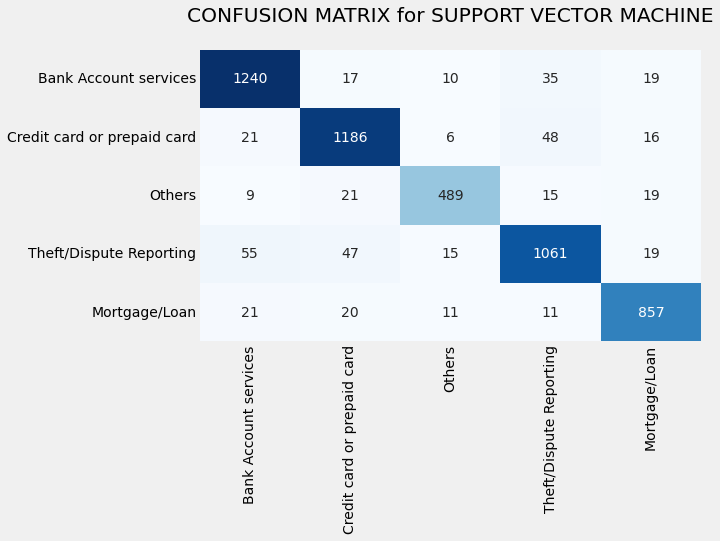

In [98]:
# Evaluate the SVM classifier
eval_model(y_test, y_pred_svm_tuned, model_name)

In [99]:
# Update the summary table
summary.loc[len(summary.index)] = ['Support Vector Machine', round(f1_svm, 2), round(f1_svm_tuned, 2)]
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95
2,Decision Tree,0.78,0.80
3,Random Forest,0.81,0.84
4,Support Vector Machine,0.92,0.92


The tuned Support Vector Machine gives a high `F1 score` of `0.92'

This model also performed quite well on all the topics

### Model #6: XGBoost

In [100]:
# Run XGBoost model on default hyperparameters 
model_name = 'XGBOOST'
clf_xgb = XGBClassifier(tree_method='gpu_hist', 
                        gpu_id=0, 
                        predictor="gpu_predictor")
%time
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

Wall time: 0 ns
[20:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [101]:
# Calculate F1 Score using weighted average method
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
print("The XGBoost model's F1 Score : ", round(f1_xgb, 2))

The XGBoost model's F1 Score :  0.91


In [ ]:
# # Hyperparameter tuning to improve XGBoost performance
# param_grid_xgb = {
#     'learning_rate': [0.1, 0.2],
#     'max_depth': [2, 6, 10],
#     'min_child_weight': [7, 11, 19],
#     'scale_pos_weight': [10, 12],
#     'n_estimators': [300, 500]
# }

# grid_xgb = RandomizedSearchCV(estimator=clf_xgb, 
#                               param_distributions=param_grid_xgb,
#                               scoring='f1_weighted',
#                               verbose=1,
#                               n_jobs=-1,
#                               cv=3)
# grid_xgb.fit(X_train, y_train)
# print(grid_xgb.best_params_)

**Best Estimator parameters**

{'scale_pos_weight': 12, 'n_estimators': 500, 'min_child_weight': 11, 'max_depth': 2, 'learning_rate': 0.1}

In [102]:
# Run XGBoost on tuned hyperparameters
clf_xgb_tuned = XGBClassifier(scale_pos_weight=12, 
                              n_estimators=500, 
                              min_child_weight=11, 
                              max_depth=2, 
                              learning_rate=0.1, 
                              tree_method='gpu_hist', 
                              gpu_id=0, 
                              predictor="gpu_predictor"
)
%time 
clf_xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = clf_xgb_tuned.predict(X_test)

Wall time: 0 ns
[20:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [107]:
# Calculate F1 Score of tuned model using weighted average method
f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average="weighted")
print("The Tuned XGBoost model's F1 Score : ", round(f1_xgb_tuned, 2))

The Tuned XGBoost model's F1 Score :  0.92


CLASSIFICATION REPORT for XGBOOST

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.95      0.94      1321
Credit card or prepaid card       0.92      0.93      0.92      1277
                     Others       0.91      0.92      0.91       553
    Theft/Dispute Reporting       0.92      0.88      0.90      1197
              Mortgage/Loan       0.92      0.93      0.92       920

                   accuracy                           0.92      5268
                  macro avg       0.92      0.92      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



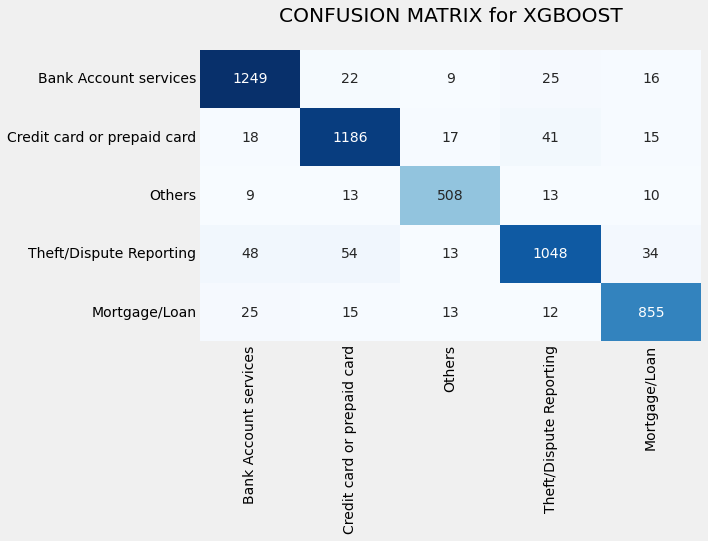

In [108]:
# Evaluate the SVM classifier
eval_model(y_test, y_pred_xgb_tuned, model_name)

In [118]:
# Update the summary table
summary.loc[len(summary.index)] = ['XGBoost', round(f1_xgb, 2), round(f1_xgb_tuned, 2)]

In [119]:
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95
2,Decision Tree,0.78,0.80
3,Random Forest,0.81,0.84
4,Support Vector Machine,0.92,0.92
6,XGBoost,0.91,0.92


The tuned XGBoost Model also gives a high `F1 score` of `0.92'

This model also performed quite well on all the topics

### Model #7: CatBoost

In [120]:
# Run the CatBoost model on default hyperparameters
model_name = 'CATBOOST'
clf_cb = CatBoostClassifier(task_type="GPU",
                           loss_function='MultiClass')
clf_cb.fit(X_train, y_train)
y_pred_cb = clf_cb.predict(X_test)

Learning rate set to 0.113981
0:	learn: 1.4128530	total: 306ms	remaining: 5m 5s
1:	learn: 1.2871712	total: 452ms	remaining: 3m 45s
2:	learn: 1.1815795	total: 611ms	remaining: 3m 22s
3:	learn: 1.1017533	total: 765ms	remaining: 3m 10s
4:	learn: 1.0372463	total: 906ms	remaining: 3m
5:	learn: 0.9798003	total: 1.06s	remaining: 2m 56s
6:	learn: 0.9326231	total: 1.22s	remaining: 2m 52s
7:	learn: 0.8894498	total: 1.37s	remaining: 2m 49s
8:	learn: 0.8504277	total: 1.53s	remaining: 2m 48s
9:	learn: 0.8182562	total: 1.68s	remaining: 2m 46s
10:	learn: 0.7897057	total: 1.83s	remaining: 2m 44s
11:	learn: 0.7628567	total: 1.98s	remaining: 2m 43s
12:	learn: 0.7384295	total: 2.12s	remaining: 2m 40s
13:	learn: 0.7163237	total: 2.26s	remaining: 2m 39s
14:	learn: 0.6971986	total: 2.4s	remaining: 2m 37s
15:	learn: 0.6813671	total: 2.53s	remaining: 2m 35s
16:	learn: 0.6640920	total: 2.68s	remaining: 2m 35s
17:	learn: 0.6483783	total: 2.83s	remaining: 2m 34s
18:	learn: 0.6343508	total: 2.95s	remaining: 2m 32

In [121]:
# Calculate F1 Score using weighted average method
f1_cb = f1_score(y_test, y_pred_cb, average="weighted")
f1_cb

0.9131252812017903

In [ ]:
# # Hyperparameter tuning to improve CatBoost performance
# param_grid_cb = {
#         'depth':[2, 3, 4],
#         'l2_leaf_reg':np.logspace(-20, -19, 3)
# }

# grid_cb = RandomizedSearchCV(estimator=clf_cb, 
#                               param_distributions=param_grid_cb,
#                               scoring='f1_weighted',
#                               verbose=1,
#                               n_jobs=-1,
#                               cv=2)
# grid_cb.fit(X_train, y_train)
# print(grid_cb.best_params_)

Best Estimator parameters

{'l2_leaf_reg': 1e-20, 'depth': 2}

In [122]:
# Run CatBoost on tuned hyperparameters
clf_cb_tuned = CatBoostClassifier(task_type="GPU",
                                  l2_leaf_reg=1e-20,
                                  depth=2
)
%time 
clf_cb_tuned.fit(X_train, y_train)
y_pred_cb_tuned = clf_cb_tuned.predict(X_test)

Wall time: 0 ns
0:	learn: 24.6319899	total: 84.7ms	remaining: 1m 24s
1:	learn: 957766195553158430720.0000000	total: 145ms	remaining: 1m 12s
2:	learn: 7309434797711235743744.0000000	total: 202ms	remaining: 1m 7s
3:	learn: 6846598238561402617856.0000000	total: 263ms	remaining: 1m 5s
4:	learn: 5365138751304652292096.0000000	total: 299ms	remaining: 59.5s
5:	learn: 6790384342208460357632.0000000	total: 322ms	remaining: 53.4s
6:	learn: 7912248458412797460480.0000000	total: 345ms	remaining: 48.9s
7:	learn: 6263796563885135233024.0000000	total: 368ms	remaining: 45.6s
8:	learn: 8354676176754683412480.0000000	total: 390ms	remaining: 43s
9:	learn: 5650626160576257064960.0000000	total: 413ms	remaining: 40.9s
10:	learn: 8117507004491133616128.0000000	total: 435ms	remaining: 39.1s
11:	learn: 4158907393577930719232.0000000	total: 458ms	remaining: 37.7s
12:	learn: 4464761915544307236864.0000000	total: 480ms	remaining: 36.4s
13:	learn: 10022586211441848614912.0000000	total: 503ms	remaining: 35.4s
14:	l

In [123]:
# Calculate F1 Score of tuned model using weighted average method
f1_cb_tuned = f1_score(y_test, y_pred_cb_tuned, average="weighted")
f1_cb_tuned

0.757521797343893

CLASSIFICATION REPORT for CATBOOST

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.93      0.93      1321
Credit card or prepaid card       0.92      0.92      0.92      1277
                     Others       0.91      0.90      0.90       553
    Theft/Dispute Reporting       0.91      0.88      0.89      1197
              Mortgage/Loan       0.91      0.93      0.92       920

                   accuracy                           0.91      5268
                  macro avg       0.91      0.91      0.91      5268
               weighted avg       0.91      0.91      0.91      5268



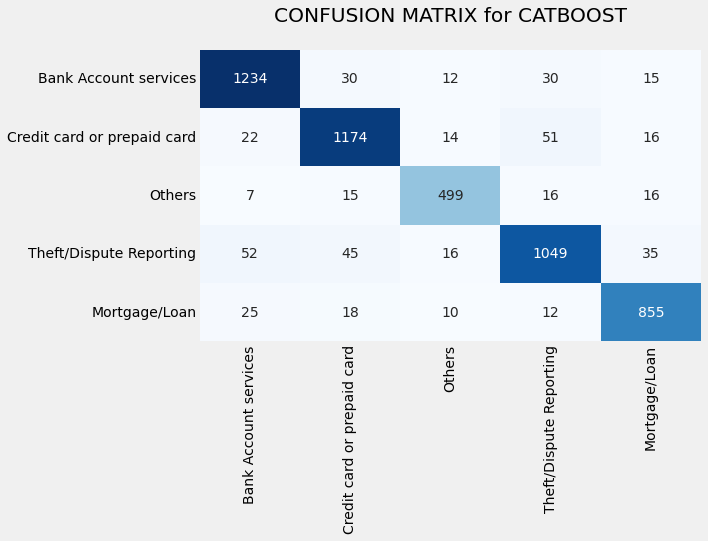

In [124]:
# Evaluate the untuned CatBoost classifier (as it performed better)
eval_model(y_test, y_pred_cb, model_name)

In [125]:
# Update the summary table
summary.loc[len(summary.index)] = ['CatBoost', round(f1_cb, 2), round(f1_cb_tuned, 2)]
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95
2,Decision Tree,0.78,0.80
3,Random Forest,0.81,0.84
4,Support Vector Machine,0.92,0.92
6,CatBoost,0.91,0.76


The untuned CatBoost model gives a pretty high `F1 score` of 0.91

 - Actually, CatBoost model is designed in a way that does not require hyper-parameter tuning 

This model also performed quite well on all the topics

### From the below summary table of `F1 Scores`, we clearly can observe that: The `Tuned Logistic Regression Model` performed the best among all the models that we have tried.

In [126]:
summary

,Model,F1 Score (Untuned Model),F1 Score (Tuned Model)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.95
2,Decision Tree,0.78,0.80
3,Random Forest,0.81,0.84
4,Support Vector Machine,0.92,0.92
6,CatBoost,0.91,0.76


___
___

## Part 8 : Model Inference

### Tuned Logistic Regression Model 

In [127]:
# First, Save tuned Logistic Regression model as pickle file
pickle.dump(clf_lr_tuned, open("logreg_model.pkl", "wb"))

In [128]:
# Function to predict a topic for given text

def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", 
                    "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
    loaded_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [129]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': 
                       ["Pathetic, I can not get details about my home mortgage and original loan documents", 
                        "The last transaction amount on my credit card, was debited twice. Bank failing to resolve it at the earliest.",
                        "I want to open an account at your main branch, despite my calling to branch multiple times, no one is providing me the procedure and other details. This is seriously horrible customer service.",
                        "Yesterday, I received a fraudulent email regarding renewal of my services. I informed bank but looks like they are not interested in resolving the issue. Such a pathetic bank.",
                        "What is the use of your online app? Most times it doesn't work properly. Also it does not offer all the services and options",
                        "You better should close down the branch at high street. Not a single employee there is responsible enough to deal with high value customers like me."]})
df_new

,complaints
0,"Pathetic, I can not get details about my home ..."
1,"The last transaction amount on my credit card,..."
2,"I want to open an account at your main branch,..."
3,"Yesterday, I received a fraudulent email regar..."
4,What is the use of your online app? Most times...
5,You better should close down the branch at hig...


In [130]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))

# Let's review it
df_new

,complaints,predicted topic
0,"Pathetic, I can not get details about my home ...",Mortgage/Loan
1,"The last transaction amount on my credit card,...",Credit card or prepaid card
2,"I want to open an account at your main branch,...",Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Bank Account services
4,What is the use of your online app? Most times...,Theft/Dispute Reporting
5,You better should close down the branch at hig...,Bank Account services


### Conclusion : 
The above observation shows that this model performs well in classification of new data